In [20]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [21]:
# 1. Carregar dados
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='Target')

# Mostrar os primeiros dados
print("🔹 Dataset (X):")
display(X.head())

# y
print("\n🔹 Target (y):")
print(y.head())
print()
print(y.describe())

🔹 Dataset (X):


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25



🔹 Target (y):
0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: Target, dtype: float64

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: Target, dtype: float64


🔹 Dimensões do dataset de original: (20640, 8)
🔹 Dimensões do dataset de treinamento: (16512, 8)
🔹 Dimensões do dataset de teste: (4128, 8)


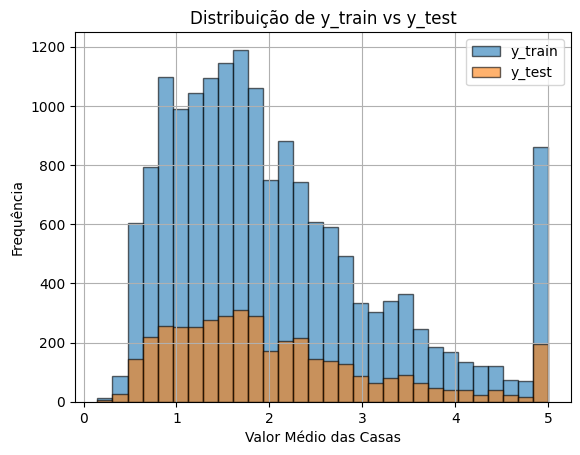

In [22]:
# 2. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("🔹 Dimensões do dataset de original:", X.shape)
print("🔹 Dimensões do dataset de treinamento:", X_train.shape)
print("🔹 Dimensões do dataset de teste:", X_test.shape)

# histograma
plt.hist(y_train, bins=30, alpha=0.6, label='y_train', edgecolor='black')
plt.hist(y_test, bins=30, alpha=0.6, label='y_test', edgecolor='black')
plt.title("Distribuição de y_train vs y_test")
plt.xlabel("Valor Médio das Casas")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.show()


=== MODELO COM PARÂMETROS PADRÃO ===
➡️ RMSE (default): 0.4718


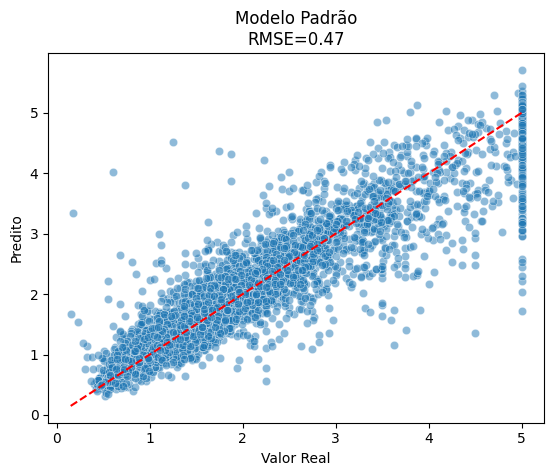

In [24]:
print("\n=== MODELO COM PARÂMETROS PADRÃO ===")

#3. Modelo com parâmetros default
model_default = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_default.fit(X_train, y_train)

# Avaliação
y_pred_default = model_default.predict(X_test)
rmse_default = np.sqrt(mean_squared_error(y_test, y_pred_default))

print(f"➡️ RMSE (default): {rmse_default:.4f}")

# Default
sns.scatterplot(x=y_test, y=y_pred_default, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Modelo Padrão\nRMSE={rmse_default:.2f}")
plt.xlabel("Valor Real")
plt.ylabel("Predito")
plt.show()

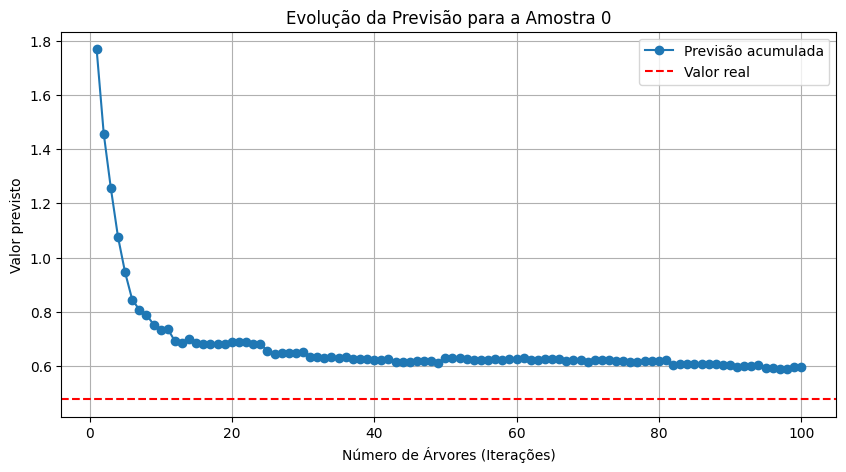

Previsão final: 0.59
Valor real: 0.48


In [25]:
# Escolher uma amostra para acompanhar a predição
sample_index = 0
sample = X_test.iloc[[sample_index]]  # Mantém como DataFrame com 1 linha

# Lista para armazenar as previsões acumuladas
tree_preds = []

# Fazer previsões incrementais (com 1, 2, ..., 100 árvores)
for i in range(1, model_default.n_estimators + 1):
    pred = model_default.predict(sample, iteration_range=(0, i), output_margin=False)
    tree_preds.append(pred[0])

# Valor real da amostra
actual_value = y_test.iloc[sample_index]

# Plotar a evolução da predição
plt.figure(figsize=(10, 5))
plt.plot(range(1, model_default.n_estimators + 1), tree_preds, marker='o', label='Previsão acumulada')
plt.axhline(y=actual_value, color='r', linestyle='--', label='Valor real')
plt.title(f'Evolução da Previsão para a Amostra {sample_index}')
plt.xlabel('Número de Árvores (Iterações)')
plt.ylabel('Valor previsto')
plt.legend()
plt.grid(True)
plt.show()

print(f"Previsão final: {tree_preds[-1]:.2f}")
print(f"Valor real: {actual_value:.2f}")

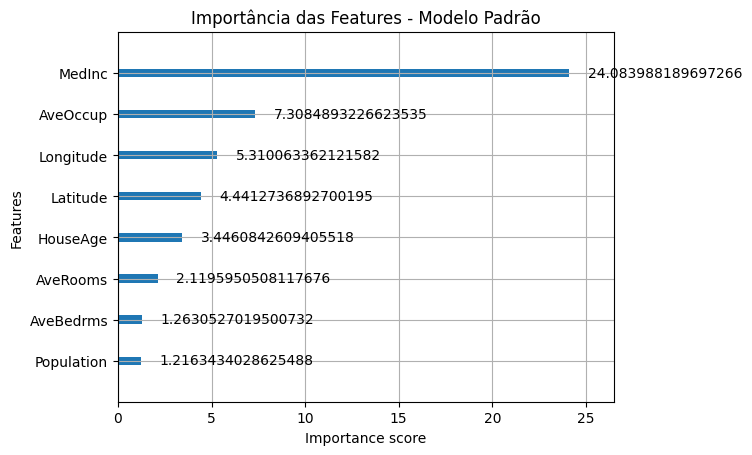

In [26]:
# Importância das features (modelo default)
xgb.plot_importance(model_default, importance_type='gain')
plt.title("Importância das Features - Modelo Padrão")
plt.show()

In [27]:
print("\n=== MODELO COM PARÂMETROS OTIMIZADOS ===")

#4. Modelo com hiperparâmetros ajustados manualmente
model_optimized = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    reg_lambda=2,
    gamma=0,
    random_state=42
)
model_optimized.fit(X_train, y_train)

# Avaliação
y_pred_opt = model_optimized.predict(X_test)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))

print(f"✅ RMSE (otimizado): {rmse_opt:.4f}")


=== MODELO COM PARÂMETROS OTIMIZADOS ===
✅ RMSE (otimizado): 0.4480


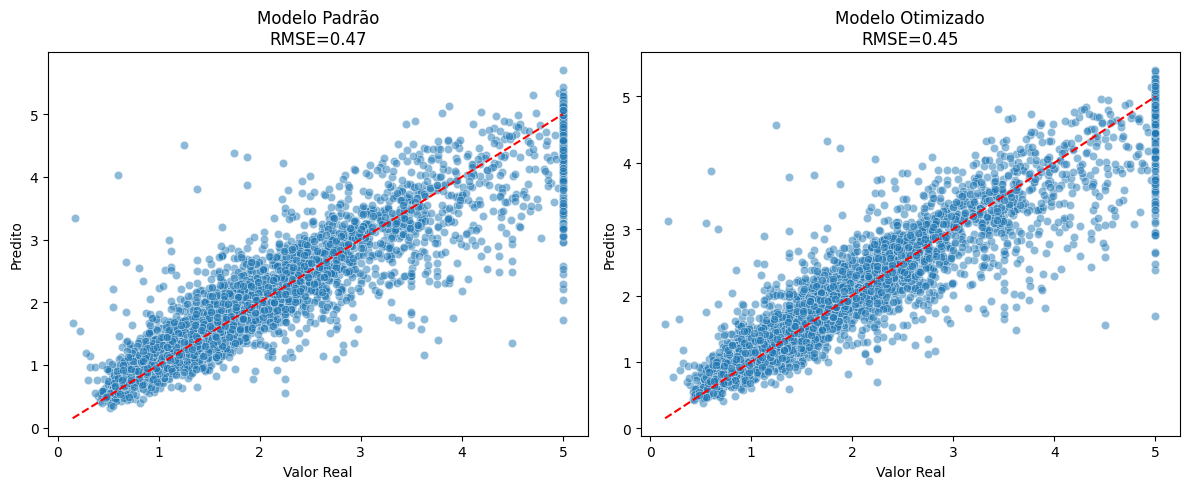

In [28]:
#5. Comparação

plt.figure(figsize=(12,5))

# Default
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_default, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Modelo Padrão\nRMSE={rmse_default:.2f}")
plt.xlabel("Valor Real")
plt.ylabel("Predito")

# Otimizado
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_opt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f"Modelo Otimizado\nRMSE={rmse_opt:.2f}")
plt.xlabel("Valor Real")
plt.ylabel("Predito")

plt.tight_layout()
plt.show()

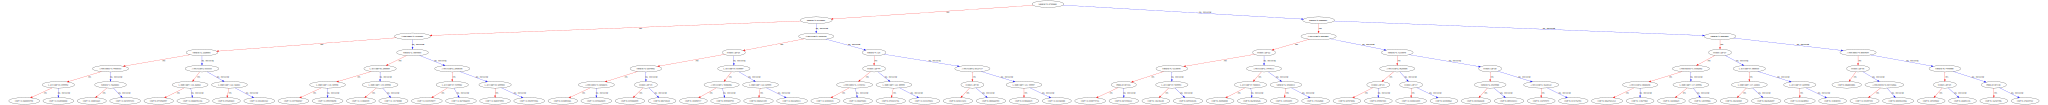

In [29]:
#6. Árvores

from xgboost import XGBRegressor, to_graphviz

# 4. Gerar o gráfico da primeira árvore na horizontal
xgb.to_graphviz(model_optimized, tree_idx=0)
